# 03 — Binomial Trees for Option Pricing

This notebook walks through the theory and implementation of **binomial tree (CRR) pricing**
for European and American options.

**Roadmap**

1. Notebook setup (imports, parameters)
2. The binomial model — one-period and multi-period
3. Risk-neutral pricing and the CRR parameterisation
4. European options as a binomial expectation
5. The spot lattice $S_{i,k}$
6. Backward induction on the option value lattice $V_{i,k}$
7. Plotly animation — backward marching through the tree
8. Pricing European options with `portfolio_analytics`
9. Continuous dividend yield — adjusting $p$
10. Discrete dividends — the prepaid forward method
11. Non-flat rate and dividend curves
12. American options — early exercise via backward induction
13. Tree Greeks (Hull Ch. 13)
14. Convergence — binomial → BSM as $N \to \infty$

## 1) Notebook Setup

We use the `portfolio_analytics` package for all pricing.
Key objects:

| Class / Enum | Purpose |
|---|---|
| `DiscountCurve.flat(...)` | Flat risk-free rate curve |
| `MarketData` | Bundles pricing date + discount curve |
| `UnderlyingPricingData` | Spot, vol, market data, dividends |
| `OptionSpec` | Contract terms (type, exercise, strike, maturity) |
| `OptionValuation` | Dispatcher — routes to binomial engine |
| `BinomialParams` | Number of tree steps, control variate settings |
| `PricingMethod.BINOMIAL` | Selects the CRR binomial engine |

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from portfolio_analytics import (
    DiscountCurve,
    MarketData,
    OptionType,
    ExerciseType,
    PricingMethod,
    GreekCalculationMethod,
    BinomialParams,
    OptionSpec,
    OptionValuation,
    UnderlyingPricingData,
)

from portfolio_analytics.utils import expected_binomial_payoff

In [2]:
# ── Market / contract parameters ──────────────────────────────────────
pricing_date = dt.datetime(2025, 1, 1)
maturity = dt.datetime(2026, 1, 1)

S0 = 100.0  # spot
K = 100.0  # strike (ATM)
sigma = 0.20  # volatility
r = 0.05  # risk-free rate
q = 0.02  # continuous dividend yield

# Build flat curves
T = 1.0  # year fraction (for display)
curve_r = DiscountCurve.flat("r", r, end_time=T)
curve_q = DiscountCurve.flat("q", q, end_time=T)

market_data = MarketData(pricing_date, curve_r, currency="USD")

underlying = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    dividend_curve=curve_q,
)

spec_call = OptionSpec(
    option_type=OptionType.CALL,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

print(f"Spot: {S0},  Strike: {K},  σ: {sigma},  r: {r},  q: {q},  T: {T}")

Spot: 100.0,  Strike: 100.0,  σ: 0.2,  r: 0.05,  q: 0.02,  T: 1.0


## 2) The Binomial Model

### One-period model

Over a single time step $\Delta t$, the stock can move to one of two values:

$$S_{\text{up}} = S_0 \, u, \qquad S_{\text{down}} = S_0 \, d,$$

where $u > 1$ is the **up multiplier** and $d < 1$ is the **down multiplier**.

The option value today is the discounted expected payoff under the **risk-neutral measure**:

$$V_0 = e^{-r \Delta t} \bigl[ p \, V_u + (1-p) \, V_d \bigr],$$

where $p$ is the **risk-neutral probability** of an up move.

### Multi-period model

Extending to $N$ steps, at each step the stock either moves up by a factor $u$ or down by $d$.  In a general (non-recombining) tree, $N$ steps would produce $2^N$ terminal nodes.  However, CRR sets $d = 1/u$, so an up-then-down move returns to the same price as a down-then-up move — the tree **recombines**.  This reduces the number of distinct terminal prices from $2^N$ to just $N + 1$:

$$S_T(j) = S_0 \, u^j \, d^{N-j}, \qquad j = 0, 1, \dots, N,$$

where $j$ is the number of up moves.  The number of paths reaching each terminal node follows a **binomial distribution** $\text{Bin}(N, p)$.

## 3) Risk-Neutral Pricing and the CRR Parameterisation

### Choosing $u$ and $d$

Cox, Ross, and Rubinstein (1979) set:

$$u = e^{\sigma \sqrt{\Delta t}}, \qquad d = \frac{1}{u} = e^{-\sigma \sqrt{\Delta t}}.$$

This ensures the tree **recombines** — an up-then-down move lands on the same node as a down-then-up move — and matches the variance of the continuous-time GBM process.

### Risk-neutral probability

The no-arbitrage condition requires $d < e^{(r-q)\Delta t} < u$.  The risk-neutral up probability is:

$$p = \frac{e^{(r-q)\Delta t} - d}{u - d}.$$

Here $r$ is the risk-free rate and $q$ is the continuous dividend yield.  When $q = 0$:

$$p = \frac{e^{r \Delta t} - d}{u - d}.$$

The factor $e^{(r-q)\Delta t}$ is the **one-step growth factor** of the prepaid forward price.  In `portfolio_analytics`, when curves are non-flat, each step can have its own forward rate $f_i$ and dividend yield $g_i$, giving step-dependent $p_i$ and discount factor $\text{df}_i$.

### Arbitrage-free condition

If $p \notin (0, 1)$ — equivalently $e^{(r-q)\Delta t} \leq d$ or $\geq u$ — the model admits arbitrage.  `portfolio_analytics` raises `ArbitrageViolationError` in this case.

In [3]:
# ── Illustrate CRR parameters ────────────────────────────────────────
N_demo = 4  # small tree for illustration
dt_step = T / N_demo

u = np.exp(sigma * np.sqrt(dt_step))
d = 1.0 / u
growth = np.exp((r - q) * dt_step)
p = (growth - d) / (u - d)

print(f"N = {N_demo} steps,  Δt = {dt_step:.4f}")
print(f"u = {u:.6f},  d = {d:.6f}")
print(f"growth = exp((r-q)Δt) = {growth:.6f}")
print(f"p = {p:.6f},  1-p = {1 - p:.6f}")
print(f"\nArbitrage check: d < growth < u → {d:.4f} < {growth:.4f} < {u:.4f} ✓")

N = 4 steps,  Δt = 0.2500
u = 1.105171,  d = 0.904837
growth = exp((r-q)Δt) = 1.007528
p = 0.512599,  1-p = 0.487401

Arbitrage check: d < growth < u → 0.9048 < 1.0075 < 1.1052 ✓


## 4) European Options as a Binomial Expectation

For a **European** option, there is no early exercise.  The price is simply the discounted risk-neutral expectation of the terminal payoff:

$$V_0 = e^{-rT} \sum_{j=0}^{N} \binom{N}{j} p^j (1-p)^{N-j} \, \text{payoff}\bigl(S_T(j)\bigr),$$

where $S_T(j) = S_0\, u^j d^{N-j}$ and the payoff is $\max(S_T - K, 0)$ for a call and $\max(K- S_T, 0)$ for a put. Here $j$ counts **up jumps** and $p$ is the probability of an up jump, so the binomial coefficient $\binom{N}{j}$ counts the number of paths with exactly $j$ ups out of $N$ steps.

This is the expected value of a function of a **Binomial(N, p)** random variable — $N$ independent Bernoulli trials, each with probability $p$ of an up move.

As $N \to \infty$ the distribution converges to a log-normal, recovering the BSM formula.

> In `portfolio_analytics`, `utils.expected_binomial_payoff()` evaluates this sum directly
> without building a lattice — useful for quick European pricing or verification.

In [4]:
# ── Direct binomial expectation (no lattice needed) ────────────────
N_steps = 200
expected_payoff = expected_binomial_payoff(
    S0=S0,
    n=N_steps,
    T=T,
    option_type=OptionType.CALL,
    K=K,
    r=r,
    q=q,
    u=np.exp(sigma * np.sqrt(T / N_steps)),
)
pv_direct = np.exp(-r * T) * expected_payoff

print(f"European call via direct binomial sum (N={N_steps}):  {pv_direct:.6f}")

# ── Compare with BSM ──────────────────────────────────────────────────
bsm_ov = OptionValuation(
    name="call_bsm",
    underlying=underlying,
    spec=spec_call,
    pricing_method=PricingMethod.BSM,
)
bsm_pv = bsm_ov.present_value()
print(f"BSM analytical price:                                {bsm_pv:.6f}")
print(f"Difference:                                         {pv_direct - bsm_pv:+.6f}")
print(
    f"Difference (%):                                     {(pv_direct - bsm_pv) / bsm_pv * 100:+.2f}%"
)

European call via direct binomial sum (N=200):  9.217292
BSM analytical price:                                9.227006
Difference:                                         -0.009714
Difference (%):                                     -0.11%


## 5) The Spot Lattice $S_{i,k}$

Because the CRR tree recombines ($ud = 1$), the stock price at node $(i, k)$ is:

$$S_{i,k} = S_0 \, u^{i-k} \, d^{k},$$

where:
- $i = 0, 1, \dots, N$ is the **time step** index (column)
- $k = 0, 1, \dots, i$ is the **state** index (row), counting the number of **down moves**

> **Relating to Hull's notation.** Hull writes $S_0 u^j d^{i-j}$ with $j$ = up jumps.
> Our $k$ counts *down* jumps, so $k = i - j$ (equivalently $j = i - k$).  The two are
> complementary descriptions of the same lattice node.

> **Indexing note.** In the PDE notebook, the spatial index $j$ increases with $S$.
> Here, $k$ counts down moves, so $k$ increasing means $S$ *decreasing*.
> The first subscript is always time in both notebooks.

The lattice has a **triangular** shape: column $i$ has $i + 1$ nodes.

We store it as an $(N{+}1) \times (N{+}1)$ upper-triangular matrix where `lattice[k, i]` = $S_{i,k}$ (row = $k$, column = $i$).  Entries with $k > i$ are unused (zero).

### Lattice layout

```
       i=0    i=1      i=2        i=3         i=4
k=0  [ S₀    S₀u     S₀u²      S₀u³       S₀u⁴  ]  ← 0 down moves (highest S)
k=1  [  0    S₀d     S₀        S₀u        S₀u²   ]  ← 1 down move
k=2  [  0      0     S₀d²      S₀d        S₀     ]
k=3  [  0      0       0       S₀d²       S₀d²   ]
k=4  [  0      0       0         0        S₀d⁴   ]  ← 4 down moves (lowest S)
```

Row $k = 0$ is always the highest spot (all up moves); row $k = i$ is the lowest (all down moves).

In [5]:
# ── Build a small spot lattice for illustration ───────────────────────
N = 4
dt_step = T / N
u = np.exp(sigma * np.sqrt(dt_step))
d = 1.0 / u

spot_lattice = np.zeros((N + 1, N + 1))
for i in range(N + 1):  # time step (column)
    for k in range(i + 1):  # state/row (down moves)
        spot_lattice[k, i] = S0 * u ** (i - k) * d**k

print("Spot lattice (4-step CRR tree):")
print("Rows = state k (counting down moves), Columns = time step i")
print()
with np.printoptions(precision=2, suppress=True, linewidth=120):
    # Show only the upper-triangular part
    display = spot_lattice.copy()
    for i in range(N + 1):
        for k in range(i + 1, N + 1):
            display[k, i] = np.nan
    print(display)

Spot lattice (4-step CRR tree):
Rows = state k (counting down moves), Columns = time step i

[[100.   110.52 122.14 134.99 149.18]
 [   nan  90.48 100.   110.52 122.14]
 [   nan    nan  81.87  90.48 100.  ]
 [   nan    nan    nan  74.08  81.87]
 [   nan    nan    nan    nan  67.03]]


## 6) Backward Induction on the Option Value Lattice $V_{i,k}$

### Terminal condition

At maturity ($i = N$):

$$V_{N,k} = \text{payoff}(S_{N,k}), \qquad k = 0, 1, \dots, N.$$

For a call: $V_{N,k} = \max(S_{N,k} - K, 0)$.

### Backward step (European)

For $i = N{-}1, N{-}2, \dots, 0$:

$$V_{i,k} = \text{df}_i \bigl[ p_i \, V_{i+1, k} + (1-p_i) \, V_{i+1, k+1} \bigr], \qquad k = 0, 1, \dots, i.$$

Here $\text{df}_i = e^{-f_i \Delta t}$ is the one-step discount factor (using the forward rate $f_i$ on interval $[t_i, t_{i+1}]$), and $p_i$ is the risk-neutral up probability for that step.  The up child is $V_{i+1,k}$ (same row — no new down move) and the down child is $V_{i+1,k+1}$ (row + 1 — one more down move).

With flat rates, $\text{df}_i$ and $p_i$ are the same at every step.

### Result

After marching all the way back, $V_{0,0}$ is the fair price of the option today.

In [6]:
# ── Manual backward induction (European call, 4 steps) ────────────
growth = np.exp((r - q) * dt_step)
p = (growth - d) / (u - d)
df = np.exp(-r * dt_step)

option_lattice = np.zeros_like(spot_lattice)

# Terminal payoff
option_lattice[:, N] = np.maximum(spot_lattice[:, N] - K, 0.0)

# Backward induction
for i in range(N - 1, -1, -1):  # time step, backward
    for k in range(i + 1):  # state/row (down moves)
        option_lattice[k, i] = df * (
            p * option_lattice[k, i + 1] + (1 - p) * option_lattice[k + 1, i + 1]
        )

print(f"European call (N={N}): V₀ = {option_lattice[0, 0]:.6f}")
print(f"BSM analytical:       V₀ = {bsm_pv:.6f}")
print()
print("Option value lattice:")
with np.printoptions(precision=4, suppress=True, linewidth=120):
    display_v = option_lattice.copy()
    for i in range(N + 1):
        for k in range(i + 1, N + 1):
            display_v[k, i] = np.nan
    print(display_v)

European call (N=4): V₀ = 8.760327
BSM analytical:       V₀ = 9.227006

Option value lattice:
[[ 8.7603 14.5739 23.394  35.5549 49.1825]
 [    nan  2.8723  5.6739 11.2081 22.1403]
 [    nan     nan  0.      0.      0.    ]
 [    nan     nan     nan  0.      0.    ]
 [    nan     nan     nan     nan  0.    ]]


## 7) Plotly Animation — Backward Marching Through the Tree

The animation below shows how backward induction works on the spot lattice:

- **Grey dots**: all lattice nodes (spot prices)
- **Blue column** (rightmost): terminal payoff — known from the contract
- **Red column**: the column currently being solved via backward induction
- The solver marches **right to left**, computing each column from the one to its right
- At $i = 0$ we arrive at the option price $V_{0,0}$

In [7]:
# ── Animated binomial tree: backward induction visualisation ──────
# Use the 4-step tree from above for the animation
N_anim = N  # 4 steps

# Collect all node positions (i = time step, S = spot)
all_x, all_S = [], []
for i in range(N_anim + 1):
    for k in range(i + 1):
        all_x.append(i)
        all_S.append(spot_lattice[k, i])

# Draw tree edges
edge_x, edge_y = [], []
for i in range(N_anim):
    for k in range(i + 1):
        # Up edge: (k, i) → (k, i+1)
        edge_x += [i, i + 1, None]
        edge_y += [spot_lattice[k, i], spot_lattice[k, i + 1], None]
        # Down edge: (k, i) → (k+1, i+1)
        edge_x += [i, i + 1, None]
        edge_y += [spot_lattice[k, i], spot_lattice[k + 1, i + 1], None]

fig_tree = go.Figure()

# Tree edges (static)
fig_tree.add_trace(
    go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(color="lightgrey", width=1),
        hoverinfo="skip",
        showlegend=False,
    )
)

# All nodes (static background)
fig_tree.add_trace(
    go.Scatter(
        x=all_x,
        y=all_S,
        mode="markers",
        marker=dict(size=8, color="grey", opacity=0.4),
        name="Lattice nodes",
        hoverinfo="skip",
    )
)

# Current spot marker at i=0
fig_tree.add_trace(
    go.Scatter(
        x=[0],
        y=[S0],
        mode="markers",
        marker=dict(size=12, color="red", symbol="circle"),
        name=f"Spot S₀={S0:.0f}",
    )
)

# Animated column (trace index = 3)
fig_tree.add_trace(
    go.Scatter(
        x=[],
        y=[],
        mode="markers",
        marker=dict(size=12, color="rgba(220,60,60,0.7)", symbol="square"),
        name="Solving column",
    )
)
ANIM_IDX = 3

# Build frames: march backward from i=N to i=0
frames = []

# Frame 0: terminal payoff (i = N)
frames.append(
    go.Frame(
        data=[
            go.Scatter(
                x=[N_anim] * (N_anim + 1),
                y=[spot_lattice[k, N_anim] for k in range(N_anim + 1)],
                mode="markers",
                marker=dict(size=12, color="rgba(60,120,200,0.8)", symbol="square"),
                name="Known (payoff)",
                customdata=[option_lattice[k, N_anim] for k in range(N_anim + 1)],
                hovertemplate="S=%{y:.2f}  V=%{customdata:.4f}<extra></extra>",
            )
        ],
        traces=[ANIM_IDX],
        name=f"i = {N_anim} (payoff)",
    )
)

# Frames 1..N: solving each column
for step_num, col in enumerate(range(N_anim - 1, -1, -1), start=1):
    n_nodes = col + 1
    colour = "rgba(220,60,60,0.7)" if col > 0 else "rgba(220,60,60,0.95)"
    sz = 12 if col > 0 else 15
    label = f"i = {col}" if col > 0 else "i = 0 (price!)"
    frames.append(
        go.Frame(
            data=[
                go.Scatter(
                    x=[col] * n_nodes,
                    y=[spot_lattice[k, col] for k in range(n_nodes)],
                    mode="markers",
                    marker=dict(size=sz, color=colour, symbol="square"),
                    name="Solving column",
                    customdata=[option_lattice[k, col] for k in range(n_nodes)],
                    hovertemplate="S=%{y:.2f}  V=%{customdata:.4f}<extra></extra>",
                )
            ],
            traces=[ANIM_IDX],
            name=label,
        )
    )

fig_tree.frames = frames

# Slider
slider_steps = [
    dict(
        args=[[f.name], dict(frame=dict(duration=600, redraw=True), mode="immediate")],
        label=f.name,
        method="animate",
    )
    for f in frames
]

fig_tree.update_layout(
    sliders=[
        dict(
            active=0,
            steps=slider_steps,
            currentvalue=dict(prefix="Step: "),
            pad=dict(t=60),
        )
    ],
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            x=0.05,
            y=1.18,
            buttons=[
                dict(
                    label="▶ Play",
                    method="animate",
                    args=[None, dict(frame=dict(duration=600, redraw=True), fromcurrent=True)],
                ),
                dict(
                    label="⏸ Pause",
                    method="animate",
                    args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")],
                ),
            ],
        )
    ],
    xaxis=dict(title="Time step i", dtick=1, range=[-0.3, N_anim + 0.3]),
    yaxis=dict(title="Spot price S"),
    title=dict(text="Binomial Tree — Backward Induction (Spot Lattice)", x=0.5),
    height=550,
    width=800,
    legend=dict(x=0.75, y=0.99, bgcolor="rgba(255,255,255,0.8)", font=dict(size=10)),
    margin=dict(t=120, b=50, l=50, r=50),
)

fig_tree.show()

### Option Value Matrix — Backward Induction Visualised

The animation above shows backward induction on the *tree*.  The view below shows the same process on the **option value matrix** $V_{i,k}$ directly.

- Each cell $(i, k)$ holds the option value at time step $i$, state $k$
- Only rows $k = 0, \ldots, i$ are active at step $i$ (the lower-right triangle is unused)
- Backward induction fills the matrix **right to left**: terminal payoff at $i = N$ is known, then each column is solved from its right neighbour

In [8]:
# ── Option value matrix animation ─────────────────────────────────
N_mat = N  # reuse the 4-step tree

# ── Build display values and text annotations for each cell ──────
val_text = []  # text to show inside each cell
for k in range(N_mat + 1):
    row = []
    for i in range(N_mat + 1):
        if k <= i:
            row.append(f"{option_lattice[k, i]:.2f}")
        else:
            row.append("")
    val_text.append(row)

# ── Colour matrices for each animation frame ─────────────────────
# Encoding: 0 = unused, 1 = not yet computed, 2 = solving now, 3 = already known
colour_map = {0: "whitesmoke", 1: "lightyellow", 2: "salmon", 3: "lightskyblue"}


def make_colours(solving_i: int) -> list[list[str]]:
    """Return an (N+1) x (N+1) matrix of CSS colours for the given solving column."""
    grid = []
    for k in range(N_mat + 1):
        row = []
        for i in range(N_mat + 1):
            if k > i:
                row.append(colour_map[0])  # unused cell
            elif i > solving_i:
                row.append(colour_map[3])  # already known
            elif i == solving_i:
                row.append(colour_map[2])  # currently solving
            else:
                row.append(colour_map[1])  # not yet reached
        grid.append(row)
    return grid


# ── Build the table figure with animation frames ─────────────────
x_labels = [f"i={i}" for i in range(N_mat + 1)]
y_labels = [f"k={k}" for k in range(N_mat + 1)]

# Initial frame: terminal column (i=N) is known
init_colours = make_colours(solving_i=N_mat)

fig_mat = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[""] + x_labels,
                fill_color="white",
                font=dict(size=13, color="black"),
                align="center",
                line_color="lightgrey",
            ),
            cells=dict(
                values=(
                    [y_labels]
                    + [[val_text[k][i] for k in range(N_mat + 1)] for i in range(N_mat + 1)]
                ),
                fill_color=(
                    [["white"] * (N_mat + 1)]
                    + [[init_colours[k][i] for k in range(N_mat + 1)] for i in range(N_mat + 1)]
                ),
                font=dict(size=12),
                align="center",
                height=30,
                line_color="lightgrey",
            ),
        )
    ]
)

# Build animation frames: solve column i = N, N-1, ..., 0
frames = []
for solving_i in range(N_mat, -1, -1):
    colours = make_colours(solving_i)
    label = f"i = {solving_i}"
    frames.append(
        go.Frame(
            data=[
                go.Table(
                    header=dict(
                        values=[""] + x_labels,
                        fill_color="white",
                        font=dict(size=13, color="black"),
                        align="center",
                        line_color="lightgrey",
                    ),
                    cells=dict(
                        values=(
                            [y_labels]
                            + [[val_text[k][i] for k in range(N_mat + 1)] for i in range(N_mat + 1)]
                        ),
                        fill_color=(
                            [["white"] * (N_mat + 1)]
                            + [[colours[k][i] for k in range(N_mat + 1)] for i in range(N_mat + 1)]
                        ),
                        font=dict(size=12),
                        align="center",
                        height=30,
                        line_color="lightgrey",
                    ),
                )
            ],
            name=label,
        )
    )

fig_mat.frames = frames

slider_steps = [
    dict(
        args=[[f.name], dict(frame=dict(duration=800, redraw=True), mode="immediate")],
        label=f.name,
        method="animate",
    )
    for f in frames
]

fig_mat.update_layout(
    sliders=[
        dict(
            active=0,
            steps=slider_steps,
            currentvalue=dict(prefix="Solving: "),
            pad=dict(t=40),
        )
    ],
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            x=0.05,
            y=1.5,
            buttons=[
                dict(
                    label="▶ Play",
                    method="animate",
                    args=[None, dict(frame=dict(duration=800, redraw=True), fromcurrent=True)],
                ),
                dict(
                    label="⏸ Pause",
                    method="animate",
                    args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")],
                ),
            ],
        )
    ],
    title=dict(
        text="Option Value Matrix V<sub>i,k</sub> — Backward Induction",
        x=0.5,
    ),
    height=410,
    width=700,
    margin=dict(t=100, b=20, l=30, r=30),
)

fig_mat.show()

## 8) Pricing European Options with `portfolio_analytics`

The package handles all the details automatically: CRR parameters, lattice construction,
backward induction, and (if requested) Greeks.

In [9]:
# ── European call via binomial tree (full engine) ─────────────────
N_steps = 500

ov_eur_call = OptionValuation(
    name="eur_call_binom",
    underlying=underlying,
    spec=spec_call,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=N_steps),
)
pv_binom = ov_eur_call.present_value()

print(f"Binomial (N={N_steps}):  {pv_binom:.6f}")
print(f"BSM analytical:       {bsm_pv:.6f}")
print(f"Error:                {pv_binom - bsm_pv:+.6f}")
print(f"Error (%):            {(pv_binom - bsm_pv) / bsm_pv * 100:+.2f}%")

Binomial (N=500):  9.223118
BSM analytical:       9.227006
Error:                -0.003887
Error (%):            -0.04%


## 9) Continuous Dividend Yield — Adjusting $p$

A continuous dividend yield $q$ reduces the risk-neutral drift.  The one-step growth factor becomes

$$\text{growth} = e^{(r - q)\Delta t}$$

and the risk-neutral probability adjusts to

$$p = \frac{e^{(r-q)\Delta t} - d}{u - d}.$$

The spot lattice itself is **unchanged** — a continuous dividend yield only affect the probabilities and discount factors, not the recombining structure.

When $r$ and $q$ come from non-flat `DiscountCurve` objects, `portfolio_analytics` uses per-step forward rates $f_i$ and dividend forwards $g_i$ extracted via `step_forward_rates()`.  This gives step-dependent $p_i$ and $\text{df}_i$ while keeping the tree fully recombining.

In [10]:
# ── Show impact of continuous dividend yield ──────────────────────
print(
    f"{'Div yield q':>12s}  {'Binom PV':>10s}  {'BSM PV':>10s}  {'Error':>10s}  {'Error (%)':>10s}"
)
print("-" * 65)

for q_test in [0.0, 0.02, 0.05, 0.08]:
    curve_q_test = DiscountCurve.flat("q", q_test, end_time=T)
    und_test = underlying.replace(dividend_curve=curve_q_test)
    md_test = MarketData(pricing_date, curve_r, currency="USD")

    ov_test = OptionValuation(
        name="test",
        underlying=und_test,
        spec=spec_call,
        pricing_method=PricingMethod.BINOMIAL,
        params=BinomialParams(num_steps=500),
    )
    ov_bsm_test = OptionValuation(
        name="test_bsm",
        underlying=und_test,
        spec=spec_call,
        pricing_method=PricingMethod.BSM,
    )
    pv_b = ov_test.present_value()
    pv_a = ov_bsm_test.present_value()
    print(
        f"{q_test:12.2f}  {pv_b:10.6f}  {pv_a:10.6f}  {pv_b - pv_a:+10.6f}  {(pv_b - pv_a) / pv_a * 100:+10.2f}%  "
    )

 Div yield q    Binom PV      BSM PV       Error   Error (%)
-----------------------------------------------------------------
        0.00   10.446585   10.450584   -0.003998       -0.04%  
        0.02    9.223118    9.227006   -0.003887       -0.04%  
        0.05    7.573295    7.577082   -0.003788       -0.05%  
        0.08    6.139226    6.142998   -0.003772       -0.06%  


## 10) Discrete Dividends — The Prepaid Forward Method

When dividends are paid as known **cash amounts** at specific dates (rather than a continuous yield), the CRR tree loses its recombining property because the stock jumps down by a fixed dollar amount on ex-dates.

### The prepaid forward approach

The standard solution (Hull §21.4) is to separate the stock price into two components:

$$S = S^* + \text{PV}(\text{remaining dividends}),$$

where $S^* = S_0 - \text{PV}(\text{all dividends})$ is the **prepaid forward price** — the stock price stripped of all future dividend value.

The CRR tree is built on $S^*$, which follows a smooth geometric process and **recombines**.
At each node $(i, k)$ the full stock price is recovered by adding back the PV of dividends remaining after $t_i$:

$$S_{i,k} = S^*_{i,k} + \text{PV}_{t_i}(\text{divs after } t_i).$$

### Why this matters for American options

For European options, discrete dividends only affect the terminal distribution — we could just use the prepaid forward in the BSM formula.  But for **American** options, the early exercise decision at each node depends on the full stock price (including remaining dividend value), so the add-back step is essential.

> In `portfolio_analytics`, `_build_spot_lattice()` handles this automatically:
> 1. Subtracts `pv_discrete_dividends(all)` from `S₀` to get $S^*$
> 2. Builds the CRR tree on $S^*$
> 3. Adds back `pv_discrete_dividends(remaining after tᵢ)` at each column $i$

In [11]:
# ── Discrete dividend example ─────────────────────────────────────
# Two $2 dividends at 3 and 9 months
discrete_divs = [
    (dt.datetime(2025, 4, 1), 2.0),
    (dt.datetime(2025, 10, 1), 2.0),
]

underlying_disc = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    discrete_dividends=discrete_divs,  # no continuous yield
)

ov_disc_eur = OptionValuation(
    name="disc_div_eur",
    underlying=underlying_disc,
    spec=spec_call,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=500),
)
ov_disc_am = OptionValuation(
    name="disc_div_am",
    underlying=underlying_disc,
    spec=OptionSpec(
        option_type=OptionType.CALL,
        exercise_type=ExerciseType.AMERICAN,
        strike=K,
        maturity=maturity,
        currency="USD",
    ),
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=500),
)

pv_disc_eur = ov_disc_eur.present_value()
pv_disc_am = ov_disc_am.present_value()

print(f"Discrete dividends: {discrete_divs}")
print(f"European call (binom N=500):  {pv_disc_eur:.6f}")
print(f"American call (binom N=500):  {pv_disc_am:.6f}")
print(f"Early exercise premium:       {pv_disc_am - pv_disc_eur:+.6f}")
print(f"Early exercise premium (%):   {(pv_disc_am - pv_disc_eur) / pv_disc_eur * 100:+.2f}%")
print()
print("Note: American call on a dividend-paying stock can have positive")
print("early exercise premium — it may be optimal to exercise just before")
print("an ex-dividend date to capture the dividend.")

Discrete dividends: [(datetime.datetime(2025, 4, 1, 0, 0), 2.0), (datetime.datetime(2025, 10, 1, 0, 0), 2.0)]
European call (binom N=500):  8.114343
American call (binom N=500):  8.245073
Early exercise premium:       +0.130730
Early exercise premium (%):   +1.61%

Note: American call on a dividend-paying stock can have positive
early exercise premium — it may be optimal to exercise just before
an ex-dividend date to capture the dividend.


## 11) Non-Flat Rate and Dividend Curves

The CRR tree generalises naturally to **term-structure** rate and dividend curves.  At each time step $i$:

1. The **forward rate** $f_i$ on $[t_i, t_{i+1}]$ is extracted from the discount curve via `step_forward_rates()`
2. The **dividend forward** $g_i$ is similarly extracted from the dividend curve
3. The one-step growth becomes $e^{(f_i - g_i)\Delta t}$, giving **step-dependent** $p_i$
4. The discount factor is $\text{df}_i = e^{-f_i \Delta t}$

The tree structure ($u$, $d$, lattice shape) remains the same — only $p_i$ and $\text{df}_i$ vary by step.

> `portfolio_analytics` handles this transparently: pass any `DiscountCurve` (flat or
> interpolated).  The engine calls `step_forward_rates()` internally.

In [19]:
# ── Non-flat rate curve example ───────────────────────────────────
# Upward-sloping rate curve: 3% → 4% → 5% → 6% over 4 quarters
times = np.array([0.0, 0.25, 0.50, 0.75, 1.0])
fwd_rates = np.array([0.03, 0.04, 0.05, 0.06])

curve_r_term = DiscountCurve.from_forwards(name="r_term", times=times, forwards=fwd_rates)

market_data_term = MarketData(pricing_date, curve_r_term, currency="USD")
underlying_term = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data_term,
    dividend_curve=curve_q,
)

ov_term = OptionValuation(
    name="term_struct",
    underlying=underlying_term,
    spec=spec_call,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=500),
)
pv_term = ov_term.present_value()
print(f"Forward rates:        {fwd_rates}")
print(f"Binomial PV (N=500):  {pv_term:.6f}")
print(f"Flat rate (r=5%) PV:  {pv_binom:.6f}")

Forward rates:        [0.03 0.04 0.05 0.06]
Binomial PV (N=500):  8.977565
Flat rate (r=5%) PV:  9.223118


## 12) American Options — Early Exercise via Backward Induction

For **American** options, the holder can exercise at any node.  The backward induction changes to:

$$V_{i,k} = \max\!\bigl(\text{intrinsic}_{i,k},\; \text{df}_i\,[p_i\,V_{i+1,k} + (1-p_i)\,V_{i+1,k+1}]\bigr),$$

where $\text{intrinsic}_{i,k} = \max(S_{i,k} - K, 0)$ for a call (or $\max(K - S_{i,k}, 0)$ for a put).

At each node we compare the **continuation value** (holding the option) with the **exercise value** (exercising now) and take the maximum.

### Why trees excel at American options

1. The lattice structure naturally represents all possible exercise decisions
2. Backward induction computes the optimal policy — no need for regression (cf. Longstaff–Schwartz for MC)
3. The exercise boundary $S^*(t)$ emerges naturally as the set of nodes where exercise is optimal
4. Computational cost is $\mathcal{O}(N^2)$ — fast for a single option

In [13]:
# ── American put vs European put ──────────────────────────────────
spec_eur_put = OptionSpec(
    option_type=OptionType.PUT,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)
spec_am_put = OptionSpec(
    option_type=OptionType.PUT,
    exercise_type=ExerciseType.AMERICAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

N_steps = 500

ov_eur_put = OptionValuation(
    name="eur_put",
    underlying=underlying,
    spec=spec_eur_put,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=N_steps),
)
ov_am_put = OptionValuation(
    name="am_put",
    underlying=underlying,
    spec=spec_am_put,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=N_steps),
)

pv_eur_put = ov_eur_put.present_value()
pv_am_put = ov_am_put.present_value()

# BSM European put for reference
ov_bsm_put = OptionValuation(
    name="bsm_put",
    underlying=underlying,
    spec=spec_eur_put,
    pricing_method=PricingMethod.BSM,
)
pv_bsm_put = ov_bsm_put.present_value()

print(f"BSM European Put:       {pv_bsm_put:.6f}")
print(f"Binomial European Put:  {pv_eur_put:.6f}")
print(f"Binomial American Put:  {pv_am_put:.6f}")
print(f"\nEarly exercise premium: {pv_am_put - pv_eur_put:.6f}")
print(f"  (as % of European):   {(pv_am_put - pv_eur_put) / pv_eur_put * 100:.2f}%")

BSM European Put:       6.330081
Binomial European Put:  6.326194
Binomial American Put:  6.658816

Early exercise premium: 0.332622
  (as % of European):   5.26%


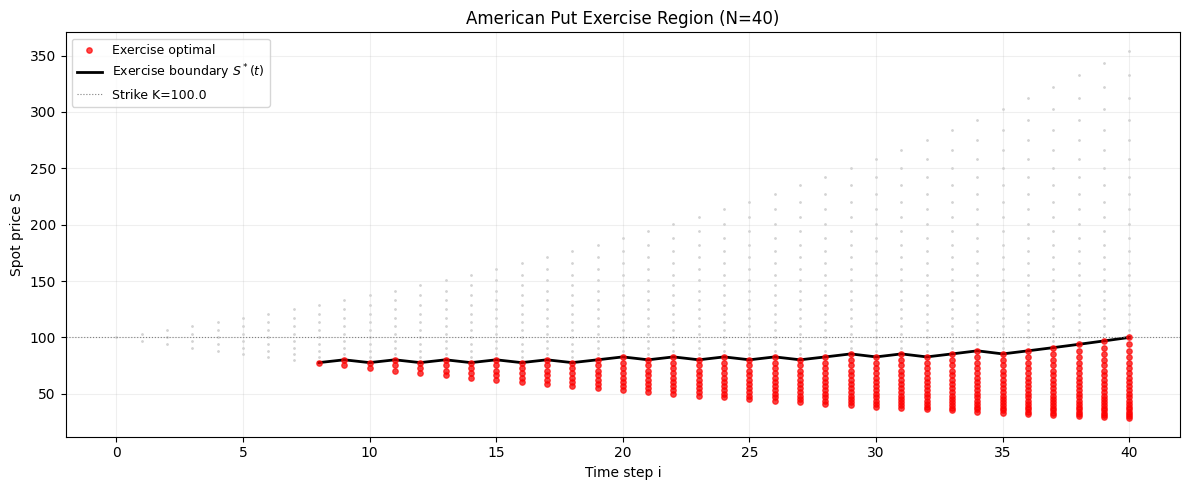

In [14]:
# ── Visualise American vs European put backward induction ────────
# Use a small tree (N=40) to illustrate the exercise boundary
N_vis = 40
dt_vis = T / N_vis
u_vis = np.exp(sigma * np.sqrt(dt_vis))
d_vis = 1.0 / u_vis
growth_vis = np.exp((r - q) * dt_vis)
p_vis = (growth_vis - d_vis) / (u_vis - d_vis)
df_vis = np.exp(-r * dt_vis)

# Build spot lattice (i = time step, k = state/row = down moves)
spot_vis = np.zeros((N_vis + 1, N_vis + 1))
for i in range(N_vis + 1):
    for k in range(i + 1):
        spot_vis[k, i] = S0 * u_vis ** (i - k) * d_vis**k

# European put (backward induction)
# V_eur = np.zeros_like(spot_vis)
# V_eur[:, N_vis] = np.maximum(K - spot_vis[:, N_vis], 0.0)
# for i in range(N_vis - 1, -1, -1):
#     for k in range(i + 1):
#         V_eur[k, i] = df_vis * (p_vis * V_eur[k, i + 1] + (1 - p_vis) * V_eur[k + 1, i + 1])

# American put (max of continuation and intrinsic)
V_am = np.zeros_like(spot_vis)
V_am[:, N_vis] = np.maximum(K - spot_vis[:, N_vis], 0.0)
exercise = np.zeros_like(spot_vis, dtype=bool)  # track where exercise is optimal
exercise[:, N_vis] = V_am[:, N_vis] > 0.0  # exercise at maturity if in the money

for i in range(N_vis - 1, -1, -1):
    for k in range(i + 1):
        cont = df_vis * (p_vis * V_am[k, i + 1] + (1 - p_vis) * V_am[k + 1, i + 1])
        intrinsic = max(K - spot_vis[k, i], 0.0)
        if intrinsic > cont:
            V_am[k, i] = intrinsic
            exercise[k, i] = True
        else:
            V_am[k, i] = cont

# Plot exercise region
fig, ax = plt.subplots(figsize=(12, 5))

# All nodes (grey)
for i in range(N_vis + 1):
    for k in range(i + 1):
        ax.plot(i, spot_vis[k, i], ".", color="lightgrey", markersize=2)

# Exercise nodes (red)
ex_i, ex_S = [], []
for i in range(N_vis + 1):
    for k in range(i + 1):
        if exercise[k, i]:
            ex_i.append(i)
            ex_S.append(spot_vis[k, i])

ax.scatter(ex_i, ex_S, c="red", s=15, zorder=5, label="Exercise optimal", alpha=0.7)

# Exercise boundary (highest S where exercise is still optimal at each step)
boundary_i, boundary_S = [], []
for i in range(N_vis + 1):
    ex_spots = [spot_vis[k, i] for k in range(i + 1) if exercise[k, i]]
    if ex_spots:
        boundary_i.append(i * dt_vis)
        boundary_S.append(max(ex_spots))  # highest S still in exercise region

if boundary_i:
    ax.plot(
        [i_val / dt_vis for i_val in boundary_i],
        boundary_S,
        "k-",
        lw=2,
        label="Exercise boundary $S^*(t)$",
    )

ax.axhline(K, color="grey", ls=":", lw=0.8, label=f"Strike K={K}")
ax.set_xlabel("Time step i")
ax.set_ylabel("Spot price S")
ax.set_title(f"American Put Exercise Region (N={N_vis})")
ax.legend(fontsize=9)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Observations

- Below the **exercise boundary** $S^*(t)$, it is optimal to exercise the put immediately
- At maturity ($i = N$), $S^* = K$ — exercise whenever the put is in the money
- The **early exercise premium** is always non-negative: $V_{\text{Am}} \geq V_{\text{Eur}}$

## 13) Tree Greeks (Hull Ch. 13)

Greeks can be extracted directly from the binomial lattice without bump-and-revalue.  This is faster and avoids numerical noise from finite differencing. Again using the notation, $V_{i,k}$ where i represents the time step and k represents the number of down jumps,

### Delta

From the two nodes at step $i = 1$:

$$\Delta = \frac{V_{1,0} - V_{1,1}}{S_{1,0} - S_{1,1}} = \frac{f_u - f_d}{S_u - S_d}.$$

### Gamma

From the three nodes at step $i = 2$:

$$\Delta_+ = \frac{V_{2,0} - V_{2,1}}{S_{2,0} - S_{2,1}}, \qquad \Delta_- = \frac{V_{2,1} - V_{2,2}}{S_{2,1} - S_{2,2}},$$

$$\Gamma = \frac{\Delta_+ - \Delta_-}{h}, \qquad h = \frac{S_{2,0} - S_{2,2}}{2}.$$

### Theta

Using the central node at step $i = 2$ vs the root:

$$\Theta = \frac{V_{2,1} - V_{0,0}}{2\Delta t},$$

returned per calendar day (divided by 365).

> In `portfolio_analytics`, tree Greeks are the **default** for binomial pricing.
> Pass `greek_calc_method=GreekCalculationMethod.NUMERICAL` to use bump-and-revalue instead.

In [15]:
# ── Tree Greeks vs BSM analytical Greeks ──────────────────────────
# European call
ov_greeks = OptionValuation(
    name="greeks_binom",
    underlying=underlying,
    spec=spec_call,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=500),
)

# BSM reference
ov_greeks_bsm = OptionValuation(
    name="greeks_bsm",
    underlying=underlying,
    spec=spec_call,
    pricing_method=PricingMethod.BSM,
)

print(f"{'Greek':>8s}  {'Tree':>10s}  {'BSM':>10s}  {'Diff':>10s}")
print("-" * 45)

for greek_name in ["delta", "gamma", "theta"]:
    tree_val = getattr(ov_greeks, greek_name)()
    bsm_val = getattr(ov_greeks_bsm, greek_name)()
    print(f"{greek_name:>8s}  {tree_val:10.6f}  {bsm_val:10.6f}  {tree_val - bsm_val:+10.6f}")

# Also show numerical (bump-and-revalue) for comparison
print("\nNumerical (bump-and-revalue) for comparison:")
print(f"{'Greek':>8s}  {'Numerical':>10s}  {'BSM':>10s}")
print("-" * 35)
for greek_name in ["delta", "gamma", "theta"]:
    num_val = getattr(ov_greeks, greek_name)(greek_calc_method=GreekCalculationMethod.NUMERICAL)
    bsm_val = getattr(ov_greeks_bsm, greek_name)()
    print(f"{greek_name:>8s}  {num_val:10.6f}  {bsm_val:10.6f}")

   Greek        Tree         BSM        Diff
---------------------------------------------
   delta    0.586827    0.586851   -0.000024
   gamma    0.018982    0.018951   +0.000031
   theta   -0.013961   -0.013943   -0.000018

Numerical (bump-and-revalue) for comparison:
   Greek   Numerical         BSM
-----------------------------------
   delta    0.586804    0.586851
   gamma    0.033883    0.018951
   theta   -0.013947   -0.013943


## 14) Convergence — Binomial → BSM as $N \to \infty$

The binomial price converges to the BSM price as the number of steps increases.  The convergence
is $\mathcal{O}(1/N)$ and exhibits a characteristic **sawtooth** pattern — even and odd $N$ converge
from opposite sides.

The plot below uses consecutive step counts $N = 10, 11, 12, \ldots, 300$ so the sawtooth is
clearly visible.

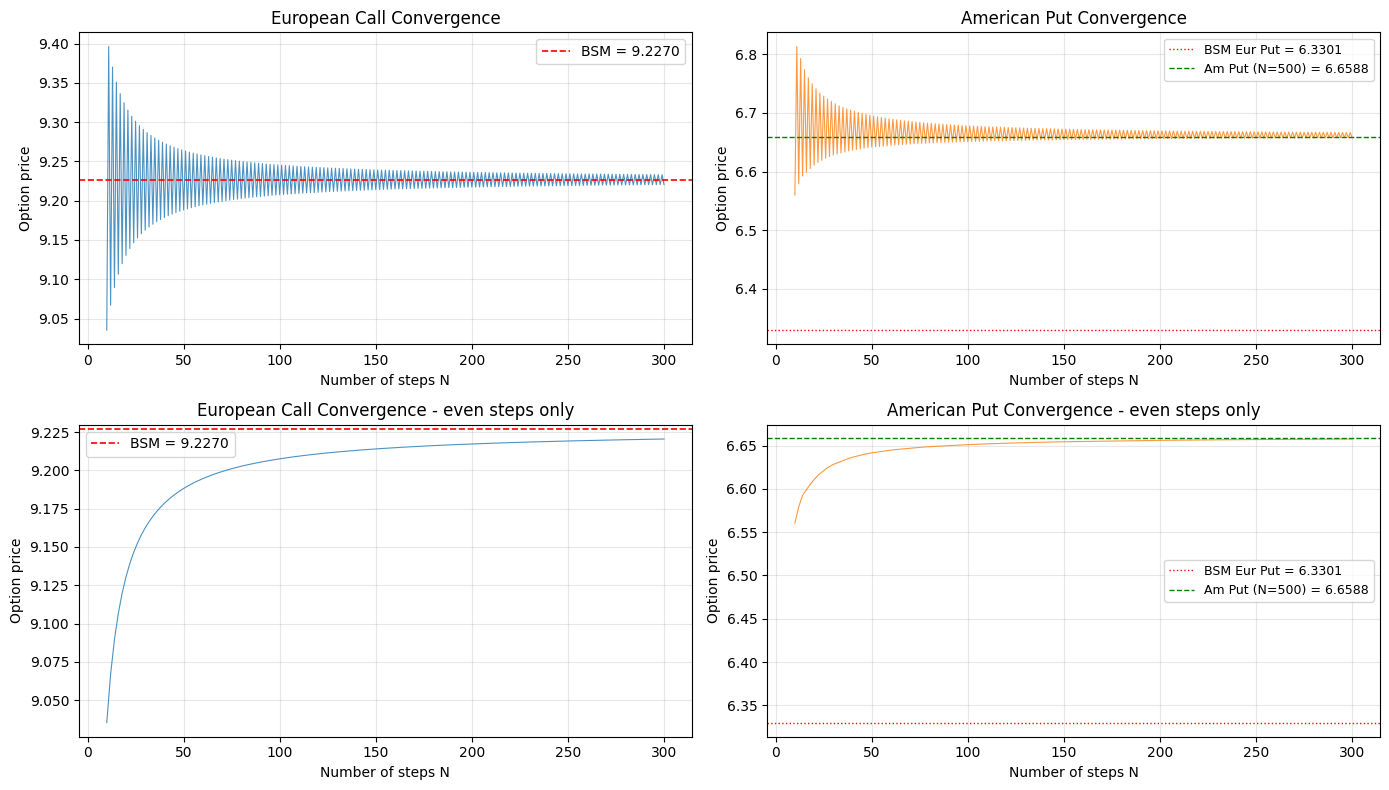

In [16]:
# ── Convergence plot ──────────────────────────────────────────────
step_range = list(range(10, 301))  # consecutive N to show sawtooth

# European call convergence
call_pvs = []
for n in step_range:
    ov = OptionValuation(
        name="conv",
        underlying=underlying,
        spec=spec_call,
        pricing_method=PricingMethod.BINOMIAL,
        params=BinomialParams(num_steps=n),
    )
    call_pvs.append(ov.present_value())

# American put convergence
put_pvs = []
for n in step_range:
    ov = OptionValuation(
        name="conv",
        underlying=underlying,
        spec=spec_am_put,
        pricing_method=PricingMethod.BINOMIAL,
        params=BinomialParams(num_steps=n),
    )
    put_pvs.append(ov.present_value())

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# European call
ax = axes[0, 0]
ax.plot(step_range, call_pvs, lw=0.8, alpha=0.8)
ax.axhline(bsm_pv, color="red", ls="--", lw=1.2, label=f"BSM = {bsm_pv:.4f}")
ax.set_xlabel("Number of steps N")
ax.set_ylabel("Option price")
ax.set_title("European Call Convergence")
ax.legend()
ax.grid(alpha=0.3)

# American put
ax2 = axes[0, 1]
ax2.plot(step_range, put_pvs, lw=0.8, alpha=0.8, color="tab:orange")
ax2.axhline(pv_bsm_put, color="red", ls=":", lw=1.0, label=f"BSM Eur Put = {pv_bsm_put:.4f}")
ax2.axhline(pv_am_put, color="green", ls="--", lw=1.0, label=f"Am Put (N=500) = {pv_am_put:.4f}")
ax2.set_xlabel("Number of steps N")
ax2.set_ylabel("Option price")
ax2.set_title("American Put Convergence")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

ax3 = axes[1, 0]
ax3.plot(step_range[::2], call_pvs[::2], lw=0.8, alpha=0.8)
ax3.axhline(bsm_pv, color="red", ls="--", lw=1.2, label=f"BSM = {bsm_pv:.4f}")
ax3.set_xlabel("Number of steps N")
ax3.set_ylabel("Option price")
ax3.set_title("European Call Convergence - even steps only")
ax3.legend()
ax3.grid(alpha=0.3)

ax2 = axes[1, 1]
ax2.plot(step_range[::2], put_pvs[::2], lw=0.8, alpha=0.8, color="tab:orange")
ax2.axhline(pv_bsm_put, color="red", ls=":", lw=1.0, label=f"BSM Eur Put = {pv_bsm_put:.4f}")
ax2.axhline(pv_am_put, color="green", ls="--", lw=1.0, label=f"Am Put (N=500) = {pv_am_put:.4f}")
ax2.set_xlabel("Number of steps N")
ax2.set_ylabel("Option price")
ax2.set_title("American Put Convergence - even steps only")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Control variate acceleration

The BSM European price is known analytically.  A simple **control variate** technique can reduce binomial pricing error for American options:

$$\hat{V}_{\text{Am}} = V^{\text{tree}}_{\text{Am}} + (V^{\text{BSM}}_{\text{Eur}} - V^{\text{tree}}_{\text{Eur}}),$$

which corrects for the tree's European pricing error (which is correlated with the American error).

> In `portfolio_analytics`, set `BinomialParams(control_variate_european=True)` to enable this.

In [17]:
# ── Control variate for American put ──────────────────────────────
print(f"{'N':>6s}  {'No CV':>10s}  {'With CV':>10s}  {'Am Put (N=2000)':>16s}")
print("-" * 50)

# High-accuracy reference
ov_ref = OptionValuation(
    name="ref",
    underlying=underlying,
    spec=spec_am_put,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=2000),
)
pv_ref = ov_ref.present_value()

for n in [5, 10, 25, 50]:
    ov_no_cv = OptionValuation(
        name="no_cv",
        underlying=underlying,
        spec=spec_am_put,
        pricing_method=PricingMethod.BINOMIAL,
        params=BinomialParams(num_steps=n, control_variate_european=False),
    )
    ov_cv = OptionValuation(
        name="cv",
        underlying=underlying,
        spec=spec_am_put,
        pricing_method=PricingMethod.BINOMIAL,
        params=BinomialParams(num_steps=n, control_variate_european=True),
    )
    print(
        f"{n:6d}  {ov_no_cv.present_value():10.6f}  {ov_cv.present_value():10.6f}  {pv_ref:16.6f}"
    )

     N       No CV     With CV   Am Put (N=2000)
--------------------------------------------------
     5    6.974637    6.599154          6.660226
    10    6.560329    6.752009          6.660226
    25    6.728412    6.654239          6.660226
    50    6.641549    6.680329          6.660226


---

## Summary

| Topic | Key takeaway |
|---|---|
| **CRR tree** | $u = e^{\sigma\sqrt{\Delta t}}$, $d = 1/u$, recombining lattice |
| **Risk-neutral $p$** | $p = (e^{(r-q)\Delta t} - d)/(u - d)$; must lie in $(0, 1)$ |
| **European** | Binomial expectation = $N$ Bernoulli trials, no lattice needed |
| **Backward induction** | March $i = N \to 0$: $V_{i,k} = \text{df}\,[p\,V_{i+1,k} + (1-p)\,V_{i+1,k+1}]$ |
| **American** | Max of continuation and intrinsic at each node |
| **Continuous divs** | Adjust $p$ via growth $= e^{(r-q)\Delta t}$ |
| **Discrete divs** | Prepaid forward: tree on $S^*$, add back PV(remaining) |
| **Non-flat curves** | Step-dependent $p_i$, $\text{df}_i$ from `step_forward_rates()` |
| **Tree Greeks** | $\Delta$ from step 1, $\Gamma$ from step 2, $\Theta$ from step 2 |
| **Convergence** | $\mathcal{O}(1/N)$, sawtooth pattern; control variate accelerates |

**Notation:**
- $i$ = time step (column), $k$ = state / down-jump count (row)
- $S_{i,k} = S_0\,u^{i-k}\,d^k$ — Hull writes $S_0 u^j d^{i-j}$ with $j = i - k$ (up jumps)
- `lattice[k, i]` in numpy (row, col)

**References:**
- Hull, *Options, Futures, and Other Derivatives*, Ch. 13 & 21
- Cox, Ross, Rubinstein (1979), *Option Pricing: A Simplified Approach*